In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [4]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    labels = dataframe["label"] - 1#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [5]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
(12056, 51) (12056, 6)


In [6]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION


2022-05-31 01:26:51.734636: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 01:26:51.734726: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-05-31 01:26:51.738157: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0: 0.5412691829116549
1: 0.25964330153463294
2: 0.11406055578598093
3: 0.047698050601410205
4: 0.02789299046038988
5: 0.009435918705931148

TEST DISTRIBUTION
0: 0.5655058043117744
1: 0.2462686567164179
2: 0.11525704809286899
3: 0.0472636815920398
4: 0.02155887230514096
5: 0.0041459369817578775


In [7]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.88208077 0.4231284  0.18587909 0.07773126 0.04545589 0.01537727]
[1.1336830354812486, 2.3633488199728907, 5.379841313829198, 12.86483792437417, 21.99935109744282, 65.03104884848482]


In [8]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [9]:
class_weights[3] = class_weights[3]*2.5
class_weights[4] = class_weights[4]*2

In [10]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [12]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [13]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [14]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,class_weight = class_weights,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
593/603 [============================>.] - ETA: 0s - loss: 1.3304 - tp: 126.0000 - fp: 100.0000 - tn: 47340.0000 - fn: 9362.0000 - accuracy: 0.8338 - precision: 0.5575 - recall: 0.0133 - auc: 0.7779 - prc: 0.3473
Epoch 1: val_loss improved from inf to 0.21180, saving model to weights.best.onlyfocalloss


2022-05-31 01:28:07.415097: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 9s 10ms/step - loss: 1.3284 - tp: 134.0000 - fp: 103.0000 - tn: 48117.0000 - fn: 9510.0000 - accuracy: 0.8339 - precision: 0.5654 - recall: 0.0139 - auc: 0.7790 - prc: 0.3490 - val_loss: 0.2118 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 6030.0000 - val_fn: 1204.0000 - val_accuracy: 0.8336 - val_precision: 1.0000 - val_recall: 0.0017 - val_auc: 0.8494 - val_prc: 0.5174
Epoch 2/200
599/603 [============================>.] - ETA: 0s - loss: 1.0726 - tp: 662.0000 - fp: 225.0000 - tn: 47695.0000 - fn: 8922.0000 - accuracy: 0.8409 - precision: 0.7463 - recall: 0.0691 - auc: 0.8304 - prc: 0.4630
Epoch 2: val_loss improved from 0.21180 to 0.16264, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 3s 6ms/step - loss: 1.0705 - tp: 673.0000 - fp: 226.0000 - tn: 47994.0000 - fn: 

Epoch 13/200
598/603 [============================>.] - ETA: 0s - loss: 0.7103 - tp: 3063.0000 - fp: 498.0000 - tn: 47342.0000 - fn: 6505.0000 - accuracy: 0.8780 - precision: 0.8602 - recall: 0.3201 - auc: 0.9277 - prc: 0.7354
Epoch 13: val_loss did not improve from 0.10804
603/603 [==============================] - 2s 3ms/step - loss: 0.7085 - tp: 3082.0000 - fp: 504.0000 - tn: 47716.0000 - fn: 6562.0000 - accuracy: 0.8779 - precision: 0.8595 - recall: 0.3196 - auc: 0.9275 - prc: 0.7345 - val_loss: 0.1270 - val_tp: 405.0000 - val_fp: 37.0000 - val_tn: 5993.0000 - val_fn: 801.0000 - val_accuracy: 0.8842 - val_precision: 0.9163 - val_recall: 0.3358 - val_auc: 0.9543 - val_prc: 0.8205
Epoch 14/200
592/603 [============================>.] - ETA: 0s - loss: 0.7084 - tp: 3027.0000 - fp: 468.0000 - tn: 46892.0000 - fn: 6445.0000 - accuracy: 0.8784 - precision: 0.8661 - recall: 0.3196 - auc: 0.9275 - prc: 0.7363
Epoch 14: val_loss did not improve from 0.10804
603/603 [========================

INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 4s 7ms/step - loss: 0.6251 - tp: 4169.0000 - fp: 574.0000 - tn: 47646.0000 - fn: 5475.0000 - accuracy: 0.8955 - precision: 0.8790 - recall: 0.4323 - auc: 0.9417 - prc: 0.7872 - val_loss: 0.0994 - val_tp: 715.0000 - val_fp: 41.0000 - val_tn: 5989.0000 - val_fn: 491.0000 - val_accuracy: 0.9265 - val_precision: 0.9458 - val_recall: 0.5929 - val_auc: 0.9720 - val_prc: 0.8947
Epoch 25/200
597/603 [============================>.] - ETA: 0s - loss: 0.6296 - tp: 4058.0000 - fp: 561.0000 - tn: 47199.0000 - fn: 5494.0000 - accuracy: 0.8943 - precision: 0.8785 - recall: 0.4248 - auc: 0.9412 - prc: 0.7847
Epoch 25: val_loss did not improve from 0.09940
603/603 [==============================] - 2s 3ms/step - loss: 0.6293 - tp: 4104.0000 - fp: 565.0000 - tn: 47655.0000 - fn: 5540.0000 - accuracy: 0.8945 - precision: 0.8790 - recall: 0.4255 - auc: 0.9413 - prc: 0.7851 - val_loss: 0.1070 - 

Epoch 36/200
597/603 [============================>.] - ETA: 0s - loss: 0.6073 - tp: 4399.0000 - fp: 540.0000 - tn: 47220.0000 - fn: 5153.0000 - accuracy: 0.9007 - precision: 0.8907 - recall: 0.4605 - auc: 0.9484 - prc: 0.8090
Epoch 36: val_loss did not improve from 0.09234
603/603 [==============================] - 2s 3ms/step - loss: 0.6056 - tp: 4451.0000 - fp: 541.0000 - tn: 47679.0000 - fn: 5193.0000 - accuracy: 0.9009 - precision: 0.8916 - recall: 0.4615 - auc: 0.9486 - prc: 0.8099 - val_loss: 0.1029 - val_tp: 693.0000 - val_fp: 45.0000 - val_tn: 5985.0000 - val_fn: 513.0000 - val_accuracy: 0.9229 - val_precision: 0.9390 - val_recall: 0.5746 - val_auc: 0.9705 - val_prc: 0.8851
Epoch 37/200
590/603 [============================>.] - ETA: 0s - loss: 0.5977 - tp: 4243.0000 - fp: 551.0000 - tn: 46649.0000 - fn: 5197.0000 - accuracy: 0.8985 - precision: 0.8851 - recall: 0.4495 - auc: 0.9480 - prc: 0.8068
Epoch 37: val_loss did not improve from 0.09234
603/603 [========================

Epoch 48/200
592/603 [============================>.] - ETA: 0s - loss: 0.5810 - tp: 4714.0000 - fp: 492.0000 - tn: 46868.0000 - fn: 4758.0000 - accuracy: 0.9076 - precision: 0.9055 - recall: 0.4977 - auc: 0.9532 - prc: 0.8303
Epoch 48: val_loss did not improve from 0.08553
603/603 [==============================] - 2s 3ms/step - loss: 0.5802 - tp: 4804.0000 - fp: 502.0000 - tn: 47718.0000 - fn: 4840.0000 - accuracy: 0.9077 - precision: 0.9054 - recall: 0.4981 - auc: 0.9534 - prc: 0.8309 - val_loss: 0.1057 - val_tp: 721.0000 - val_fp: 57.0000 - val_tn: 5973.0000 - val_fn: 485.0000 - val_accuracy: 0.9251 - val_precision: 0.9267 - val_recall: 0.5978 - val_auc: 0.9677 - val_prc: 0.8770
Epoch 49/200
593/603 [============================>.] - ETA: 0s - loss: 0.5966 - tp: 4631.0000 - fp: 551.0000 - tn: 46889.0000 - fn: 4857.0000 - accuracy: 0.9050 - precision: 0.8937 - recall: 0.4881 - auc: 0.9498 - prc: 0.8161
Epoch 49: val_loss did not improve from 0.08553
603/603 [========================

Epoch 60/200
595/603 [============================>.] - ETA: 0s - loss: 0.5796 - tp: 4641.0000 - fp: 576.0000 - tn: 47024.0000 - fn: 4879.0000 - accuracy: 0.9045 - precision: 0.8896 - recall: 0.4875 - auc: 0.9526 - prc: 0.8206
Epoch 60: val_loss did not improve from 0.08553
603/603 [==============================] - 2s 3ms/step - loss: 0.5799 - tp: 4687.0000 - fp: 582.0000 - tn: 47638.0000 - fn: 4957.0000 - accuracy: 0.9043 - precision: 0.8895 - recall: 0.4860 - auc: 0.9525 - prc: 0.8202 - val_loss: 0.1175 - val_tp: 543.0000 - val_fp: 50.0000 - val_tn: 5980.0000 - val_fn: 663.0000 - val_accuracy: 0.9015 - val_precision: 0.9157 - val_recall: 0.4502 - val_auc: 0.9609 - val_prc: 0.8471
Epoch 61/200
596/603 [============================>.] - ETA: 0s - loss: 0.5975 - tp: 4624.0000 - fp: 537.0000 - tn: 47143.0000 - fn: 4912.0000 - accuracy: 0.9048 - precision: 0.8960 - recall: 0.4849 - auc: 0.9526 - prc: 0.8246
Epoch 61: val_loss did not improve from 0.08553
603/603 [========================

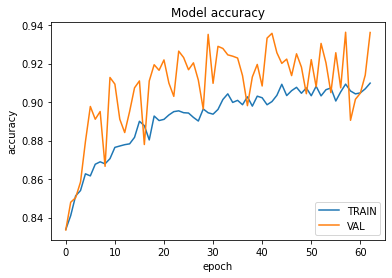

In [15]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

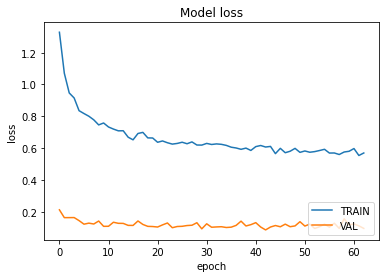

In [16]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [17]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 2ms/step - loss: 0.2336 - tp: 249.0000 - fp: 146.0000 - tn: 5884.0000 - fn: 957.0000 - accuracy: 0.8476 - precision: 0.6304 - recall: 0.2065 - auc: 0.8542 - prc: 0.5109


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.36      0.53       682
           1       0.83      0.61      0.70       297
           2       0.80      0.65      0.71       139
           3       0.08      0.75      0.15        57
           4       0.31      0.92      0.47        26
           5       0.21      1.00      0.34         5

    accuracy                           0.49      1206
   macro avg       0.54      0.72      0.48      1206
weighted avg       0.87      0.49      0.57      1206



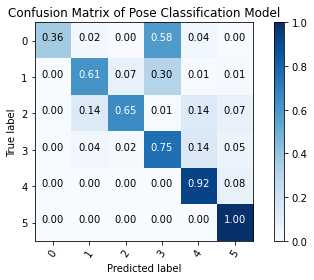

In [18]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [ ]:
#Classes 3, 4 Need to be weighted

